# Intro:
This code calculates nonlinear frequency shift for Extension and Lame
modes of a silicon bulk resonator. It takes into account only intervalley redistribution as fist described by Keyes (1967).

In short:
1. It takes analytic expressions for $\delta c_{ijkl}$ calculated in another file
    'c_ijm through F calculation.v3.ipynb'
2. This code includes known $c_{ij}$, $c_{ijk}$ for pure Si
3. It calculates analytical and/or numeric expression for elastic free energy of a mode $F = Q^2 U_2 + Q^3 U_3 + Q^4 U_4$
    using linear and nonlinear elastic consts for doped Si.
4. Using the expression for $F$, evaluate $\delta \omega^{(2)}(A)$ as described in the paper. $\delta \omega^{(2)}(A)$ can be calculated
    as a function of concentration or temperature. Both analytical and numerical values for $\delta \omega^{(2)}(A)$ can be calculated.
    
In the code, I used slightly different normalization, than that described in the paper. So some conversion is necessary (and is done below when needed). CGS units are used. Values for main parameters, like $\Xi_u$, $m$, $\Xi_{u'}$ are defined at the end of the 'Definitions' cell.

### How to use it:
First, run 'Definitions'. Then run the cells below one by one, depending on what you want to do. To use any "plot" cell, you should first run a cell above that calculates the data points that you want to plot.

You can ask questions via moskovts --at-- msu.edu

### License (MIT)
Copyright (c) 2016 Kirill Moskovtsev

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Definitions

In [3]:
'''Python version 2.7'''

%matplotlib inline
from sympy import *
from sympy import integrate as sympy_integrate
import numpy as np
from itertools import combinations_with_replacement, permutations
import fdint
from matplotlib import pyplot as plt
import pickle
from scipy.optimize import minimize
import scipy.integrate as integrate
from IPython.display import Math, display
import copy as cp

def show_math(x, s = '', prnt = False):
    display(Math(s + latex(x)))
    if prnt:
        print s + latex(x)

def R(i,j):
    return Rational(i,j)

def einsum(string, *args):
    '''
    Analog of np.einsum which works for 'object' data,
    not only numbers
    '''
    index_groups = map(list, string.split(','))
    assert len(index_groups) == len(args)
    tensor_indices_tuples = zip(index_groups, args)
    return reduce(einsum_for_two, tensor_indices_tuples)[1]

def einsum_for_two(tensor_indices1, tensor_indices2):
    '''
    component of einsum
    '''
    string1, tensor1 = tensor_indices1
    string2, tensor2 = tensor_indices2
    sum_over_indices = set(string1).intersection(set(string2))
    new_string = string1 + string2
    axes = ([], [])
    for i in sum_over_indices:
        new_string.remove(i)
        new_string.remove(i)
        axes[0].append(string1.index(i))
        axes[1].append(string2.index(i))
    return new_string, np.tensordot(tensor1, tensor2, axes)


def c_elements(doping, Tempr, numeric, poly_si = 'single'):
    '''
    Calculate entries for elastic tensors
    [[(i,j,...), ..., (k,l,..), value], .....]
    Either symbolic or numeric.
    '''
    if numeric:
        dcn = dcn_calc(doping, Tempr, poly_si)
        c = c_el_calc(dcn, Tempr, poly_si)
    else:
        c = {c11:c11, c12:c12, c44:c44, c111:c111, c112:c112, c123:c123, c144:c144, \
            c155:c155, c456:c456, c1111:c1111, c1112:c1112, c1122:c1122, c1123:c1123, \
             c1144:c1144,\
            c1155:c1155, c1244:c1244, c1266:c1266, c1456:c1456, c4444:c4444, c4455:c4455}
        if poly_si == 'isolated_gr':
            c = poly_average(c)
    elements_2d = [[(1,1), (2,2), (3,3), c[c11]], \
                       [(1,2), (1,3), (2,3), c[c12]],\
                       [(4,4), (5,5), (6,6), c[c44]]]


    #not doped
    elements_3d = [[(1,1,1), (2,2,2), (3,3,3), c[c111]],\
                    [(1,1,2), (1,1,3), (1,2,2), (1,3,3), (2,2,3), (2,3,3), c[c112]],\
                    [(1,2,3), c[c123]],\
                    [(1,4,4), (2,5,5), (3,6,6), c[c144]],\
                    [(1,5,5), (1,6,6), (2,4,4), (2,6,6), (3,4,4), (3,5,5), c[c155]],\
                    [(4,5,6), c[c456]]]


    elements_4d = [[(1,1,1,1), (2,2,2,2), (3,3,3,3), c[c1111]],\
                       [(1,1,1,2), (1,1,1,3), (1,2,2,2), (1,3,3,3), (2,2,2,3), (2,3,3,3),\
                        c[c1112]],\
                       [(1,1,2,2), (1,1,3,3), (2,2,3,3), c[c1122]],\
                       [(1,1,2,3), (1,2,2,3), (1,2,3,3), c[c1123]],\
                       [(1,1,4,4), (2,2,5,5), (3,3,6,6), c[c1144]],\
                       [(1,1,5,5), (1,1,6,6), (2,2,4,4), (2,2,6,6), (3,3,4,4), (3,3,5,5),\
                        c[c1155]],\
                       [(1,2,4,4), (1,2,5,5), (1,3,4,4), (1,3,6,6), (2,3,5,5), (2,3,6,6),\
                        c[c1244]],\
                       [(1,2,6,6), (1,3,5,5), (2,3,4,4), c[c1266]],\
                       [(1,4,5,6), (2,4,5,6), (3,4,5,6), c[c1456]],\
                       [(4,4,4,4), (5,5,5,5), (6,6,6,6), c[c4444]],\
                       [(4,4,5,5), (4,4,6,6), (5,5,6,6), c[c4455]]]
    return elements_2d, elements_3d, elements_4d


def poly_average(c):
    '''Read c-dictionary for iso-grain poly_si from file,
    and substitute given c-values (numeric or symbolic) into it.
    The file is prepared in c_ijm_through_F_calculation.ipynb'''
    
    ff = open('./poly_expressions/poly_c_dict.dat', 'r')
    c_poly_dict = pickle.load(ff)
    ff.close()
    c_poly = {key: c_poly_dict[key].subs(c) for key in c_poly_dict.keys()}
    return c_poly

def construct_tensor(elements, numeric):
    '''
    Takes the result of c_elements(), and creates a full tensor out of them.
    For each element (i,j,...) it makes all possible permutations and fills them with
    the right value.
    '''
    dim = len(elements[0][0])
    if numeric:
        tensor = np.zeros(tuple([6]*dim))
    else:
        tensor = np.zeros(tuple([6]*dim), dtype=object)
    for family in elements:
        val = family[-1]
        for el in family[0:-1]:
            perms = set(permutations(el))
            for p in perms:
                tensor[tuple(np.array(p) - np.array([1]*dim))] = val
    return tensor


def rotate_tensor(c, alpha, numeric):
    '''
    Transform tensor c (6*6*...) when rotating the coordinates by alpha rad around Z axis.
    '''
    #Transformation matrix to transform C tensor: Ai = A.inv.transpose
    if numeric:
        atype = float
        eins = np.einsum
    else:
        atype = object
        eins = einsum
    Ai = np.array([[cos(alpha)**2, sin(alpha)**2,  0,  0,  0, -2*cos(alpha)*sin(alpha)],\
                  [sin(alpha)**2, cos(alpha)**2,  0,  0,  0,  2*cos(alpha)*sin(alpha)],\
                  [0,    0,   1,  0,  0, 0],\
                  [0,    0,   0,  cos(alpha),   sin(alpha), 0],\
                  [0,    0,   0,  -sin(alpha),   cos(alpha), 0],\
                  [cos(alpha)*sin(alpha),    -cos(alpha)*sin(alpha), 0,  0,  \
                   0, cos(alpha)**2 - sin(alpha)**2]], dtype=atype)
    dimc = len(c.shape)
    
    if dimc == 2:
        c_rotated = eins("ij,kl,jl", Ai, Ai, c)
    elif dimc == 3:
        c_rotated = eins("ij,kl,rs,jls", Ai, Ai, Ai, c)
    elif dimc == 4:
        c_rotated = eins("ij,kl,rs,pq,jlsq", Ai, Ai, Ai, Ai, c)
    else:
        print "In Rotate_Tensor: Wrong tensor dimension!"
        c_rotated = None
    return c_rotated



def evaluate_coeff(x, doping, Tempr, omega_0n, (lxn, lyn, lzn), alpha_, d0_, Vb_, poly_si):
    '''
    Evaluate numerically the final result for omega^(2) correction
    '''
    dcn = dcn_calc(doping, Tempr, poly_si)
    subx = c_el_calc(dcn, Tempr, poly_si)
    subx[omega_0] = omega_0n
    subx.update({lx: lxn, ly: lyn, lz: lzn, alpha:alpha_, d0:d0_, Vb:(Vb_/299.) })
    #recalculate Vb from Volts to statV
    return x.evalf(subs = subx)


    
def fermihalf(x,sgn):
    """ Series approximation to the F_{1/2}(x) or F_{-1/2}(x) 
        Fermi-Dirac integral """

    f = lambda k: np.sqrt(x**2+np.pi**2*(2*k-1)**2)


    if sgn>0: # F_{1/2}(x)
        a = np.array((1.0/770751818298,-1.0/3574503105,-13.0/184757992,
              85.0/3603084,3923.0/220484,74141.0/8289,-5990294.0/7995))
        g = lambda k:np.sqrt(f(k)-x)

    else:  # F_{-1/2}(x)
        a = np.array((-1.0/128458636383,-1.0/714900621,-1.0/3553038,
                      27.0/381503,3923.0/110242,8220.0/919))
        g = lambda k:-0.5*np.sqrt(f(k)-x)/f(k)

    F = np.polyval(a,x) + 2*np.sqrt(2*np.pi)*sum(map(g,range(1,21)))
    return F

    
def dcn_calc(N_, Tempr, poly_si):
    '''
    Calculate numerical values for corrections delta_C_{ij...}
    '''
    
    T_ = Tempr*1.38/10**16      # erg = K*(erg/K)  'Tempr' in K
    Xi_u_ = params['Xiu']/(6.2415*10**11) #params is a global variable
    # erg = eV/(eV/erg) , Xi_u (Laude, Hall); 9.6 according to http://www.thompson.ece.ufl.edu/
                                #Fall2008/ApplPhysLett_89_073509-deformation.pdf
                                #Hall 1967: 8.6;
                                #Balslev, 1966: 8.6 at 70K, 9.2 at 295K
    Xi_d_ = 1.0/(6.2415*10**11)  #NOT USED# erg = eV/(eV/erg) VALUE NOT VERIFIED (Samuelsen 1971, 
    #Cercignani kinetics)
    hbar = 1.0545/10**27        # erg*s
    XiuP = params['Xiup'] # eV
    DeltaD0 = params['DeltaD0'] # eV
    
    J_ = 2.5*(2*XiuP/DeltaD0)**2
    K_ = -6.6*(2*XiuP/DeltaD0)**4    
    Xi_s2_ = -4*XiuP**2/DeltaD0/(6.2415*10**11)
    # \Xi3/DeltaE =11.4 from Hensel, DeltaE=0.8 from Laude, Ds = 4\Xi^2/DeltaE
    #Xi_s4_ = 16*XiuP**4/DeltaD0**3/(6.2415*10**11) # 
    Xi_s4_ = 0 # We don't care about fourth-order shift in the paper
    theta_0 = find_theta_0(N_, T_)   # dimensionless

    F0_ = fdint.fdk(0.5, theta_0)
    F32_ = fdint.fdk(1.5, theta_0)
    F1_ = derivative(fdint.fdk, theta_0, 0.05)
    F2_ = double_der(fdint.fdk, theta_0, 0.05)
    F3_ = triple_der(fdint.fdk, theta_0, 0.05)

    subs_list = [(N, N_), (T, T_), (Xi_u, Xi_u_), (Xi_d, Xi_d_), (F0, F0_), (F1, F1_), \
                 (F2, F2_), (F3, F3_), (F32, F32_), (J, J_), (K, K_),\
                 (theta_0s, theta_0), (Xi_s2, Xi_s2_), (Xi_s4, Xi_s4_)]
    #Choose the delta_c expressions for single- or poly-crystal (read them from files at the end of this cell)
    if poly_si == 'single':
        dc_dict = single_dc #global
    elif poly_si == 'connected_gr':
        dc_dict = conn_gr_dc
    elif poly_si == 'isolated_gr':
        dc_dict = poly_average(single_dc)
    # Calculate delta_c with the parameters specified above
    dcn_dict = {key: float(dc_dict[key].subs(subs_list)/10**12) for key in dc_dict.keys()}
    # dcn = delta_c_numeric
    
    return dcn_dict


def find_theta_0(N, T):
    """Find (chemical potential)/T for undistorted lattice.
    N in cm^(-3), T in erg"""
    res = minimize(delta_electron_density, np.array([1.]), args=(N,T), method='Nelder-Mead', tol=10**(-8))
    return res.x

def delta_electron_density(theta, N, T):    
    """This function is used to calculate \theta_0 in undistorted crystal.
    """
    m = params['m'] #g
    hbar = 1.05/10**27        # erg*s
    return np.abs(6*2**(0.5)*(m*T)**1.5/hbar**3/np.pi**2*fdint.fdk(0.5, theta) - N)/10**15
    
def derivative(f, x, step):
    '''Simple derivative of function f at point x'''
    return (f(0.5, x + step/2.) - f(0.5, x - step/2.))/step

def double_der(f, x, step):
    '''Double derivative of function f at point x'''
    return (f(0.5, x+step) + f(0.5, x-step) - 2*f(0.5, x))/step**2

def triple_der(f, x, step):
    '''Triple derivative of function f at point x'''
    return (f(0.5, x + 1.5*step) - f(0.5, x - 1.5*step) - 3.*f(0.5, x + 0.5*step) +\
            3.*f(0.5, x - 0.5*step))/step**3

def cij(T):
    '''Returns c-tensors values for pure Si.
    The temperature dependence of c_ij as described by Varshni, 1970.
    Fourth order constants are assumed 0 since there are no better estimates.'''
    
    cij0 = 16.75018
    s = 0.53297
    t = 407
    c11_ =  (cij0 - s/(np.exp(t/T) - 1))/10.
    
    cij0 = 6.50079
    s = 0.231036
    t = 334.8
    c12_ =  (cij0 - s/(np.exp(t/T) - 1))/10.

    cij0 = 8.00735
    s = 0.224966
    t = 497.4
    c44_ =  (cij0 - s/(np.exp(t/T) - 1))/10.
    if pure_nonlinear_c: #global parameter, set at the end of this cell. If True, set c_ijk !=0
        return {c11:c11_, c12:c12_, c44:c44_, c111:-7.95, c112:-4.45, c123:-0.75, c144:0.15, \
                c155:-3.1, c456:-0.86, c1111:0, c1112:0, c1122:0, c1123:0, c1144:0,\
                c1155:0, c1244:0, c1266:0, c1456:0, c4444:0, c4455:0}
    else:
        return {c11:c11_, c12:c12_, c44:c44_, c111: 0, c112:0, c123:0, c144:0, \
                c155:0, c456:0, c1111:0, c1112:0, c1122:0, c1123:0, c1144:0,\
                c1155:0, c1244:0, c1266:0, c1456:0, c4444:0, c4455:0}


def c_el_calc(dcn, T_, poly_si):
    '''
    Evaluate numerically independent elements C_{ijk...}
    Pure value + electronic correction.
    Output: dictionary that is ready to be fed into .evalf() function.
    '''
    c_pure_single = cij(T_)
    if poly_si != 'single':
        c_pure_poly = poly_average(c_pure_single)
        total_c_dict = {key: c_pure_poly[key] + dcn[key] for key in dcn.keys()}
    else:
        total_c_dict = {key: c_pure_single[key] + dcn[key] for key in dcn.keys()}  
    return total_c_dict



def U_terms(mode, doping, Tempr, alpha, numeric, poly_si):
    '''
    Returns total elastic energy U = Q^2*U2 + Q^3*U3 + Q^4*U4
    in analytic or numeric (for U_i) form. Then I store those expressions in external <U_<mode>_<dir>.dat> files.
    Then I use the expressions from the files, w/o recalculating every time.
    (integrated over the volume of the resonator)
    Actually, in numeric mode, they are recalculated every time.
    poly_si can be 'single', 'isolated_gr', 'connected_gr'
    '''
    elements_2d, elements_3d, elements_4d = c_elements(doping, Tempr, numeric, poly_si)
    #2d, 3d, 4d stand for c_ij, c_ijk, c_ijkl
    c_2d = rotate_tensor(construct_tensor(elements_2d, numeric), alpha, numeric)
    c_3d = rotate_tensor(construct_tensor(elements_3d, numeric), alpha, numeric)
    c_4d = rotate_tensor(construct_tensor(elements_4d, numeric), alpha, numeric)
    nu2s = -( -(c_2d[0,1] + c_2d[0,5]**2/c_2d[5,5])*c_2d[2,2] + c_2d[0,2]**2)/\
    ((c_2d[0,0] - c_2d[0,5]**2/c_2d[5,5])*c_2d[2,2] - c_2d[0,2]**2)
    nu3s = -c_2d[0,2]*(c_2d[0,1] - c_2d[0,0] + 2*c_2d[0,5]**2/c_2d[5,5])/\
    ((c_2d[0,0] - c_2d[0,5]**2/c_2d[5,5])*c_2d[2,2] - c_2d[0,2]**2)

    
    eta = np.array([0, 0, 0, 0, 0, 0], dtype = object)
    if mode == 'Extension':
        eta[0] = Q*sin(pi*x/lx)
        eta[1] = -nu2*Q*sin(pi*x/lx)
        eta[2] = -nu3*Q*sin(pi*x/lx)
    elif mode == 'Lame':
        beta = pi/lx
        eta[0] = -Q*sin(beta*x)*sin(beta*y)# + Q**2/2*((sin(beta*x)*sin(beta*y))**2 +\
                                           #          (cos(beta*x)*cos(beta*y))**2)
        eta[1] = Q*sin(beta*x)*sin(beta*y)# + Q**2/2*((sin(beta*x)*sin(beta*y))**2 + \
                                          #           (cos(beta*x)*cos(beta*y))**2)
    sum_2d = einsum('ij,i,j', c_2d, eta, eta).reshape((1,))[0] 
    sum_3d = einsum('ijk,i,j,k', c_3d, eta, eta, eta).reshape((1,))[0]
    sum_4d = einsum('ijkl,i,j,k,l', c_4d, eta, eta, eta, eta).reshape((1,))[0]
    if numeric:
        sum_tot = collect(expand(sum_2d/2 + sum_3d/6 + sum_4d/24), Q).subs({nu2:nu2s, nu3:nu3s})
    else:
        sum_tot = collect(expand(sum_2d/2 + sum_3d/6 + sum_4d/24), Q)
    sum_tot = get_terms_to_third_Q(sum_tot)    #Take only Q^2, Q^3, Q^4 terms
    sum_tot_int = sympy_integrate(sum_tot, (z, 0, lz))
    if mode == 'Extension':
        sum_tot_int = sympy_integrate(expand(sum_tot_int), (y, 0, ly))
        subs_table1 = {sin(pi*x/lx): sin(pi*x), cos(pi*x/lx): cos(pi*x)}
        sum_tot_int = lx*sum_tot_int.subs(subs_table1)
        #return sum_tot_int
        sum_tot_int = collect(expand(sum_tot_int.subs((sin(pi*x))**2, 1-(cos(pi*x))**2)),\
                              cos(pi*x))
        sum_tot_int = sympy_integrate(collect(sum_tot_int, cos(pi*x)), (x, 0, 1)) 
        #integrated over the volume
    if mode == 'Lame' or mode == 'Lame_110m':
        subs_table2 = {sin(pi*x/lx): sin(pi*x), cos(pi*x/lx): cos(pi*x),\
                      sin(pi*y/lx): sin(pi*y), cos(pi*y/lx): cos(pi*y)}
        sum_tot_int = lx**2*sum_tot_int.subs(subs_table2)
        sum_tot_int = collect(expand(sum_tot_int.subs((sin(pi*y))**2, 1-(cos(pi*y))**2)),\
                              cos(pi*y))
        sum_tot_int = sympy_integrate(sum_tot_int, (y, 0, 1))
        sum_tot_int = collect(expand(sum_tot_int.subs((sin(pi*x))**2, 1-(cos(pi*x))**2)),\
                              cos(pi*x))
        sum_tot_int = sympy_integrate(sum_tot_int, (x, 0, 1))
    print "integration done"
    sum_tot_int += electrostatic_energy(mode)/10**12
    sum_tot_int = collect(expand(sum_tot_int), Q)
    U = sum_tot_int
    return U
        
    
def electrostatic_energy(mode):
    '''
    Electrostatic energy in erg (retruns symbolic expression).
    Used to calculate electrostatic nonlinearity and f-correction
    due to bias voltage V_b.
    '''
    if mode == 'Extension':
        F = -lz*ly*Vb**2/d0*(1 + (Q*lx/pi/d0) + (Q*lx/pi/d0)**2 +\
                           (Q*lx/pi/d0)**3 + (Q*lx/pi/d0)**4)
    elif mode == 'Lame':
        F = -lz*ly*Vb**2/d0*(2 + (Q*lx/pi/d0)**2 + Rational(3,4)*(Q*lx/pi/d0)**4)
    else:
        print 'Mode should be either "Lame" or "Extension"'
        F = None
    return F
    
    
def get_terms_to_third_Q(expr):
    expr1 = collect(expand(expr), Q, evaluate=False)
    res_dict = {}
    for i in [2, 3, 4]:
        try:
            res_dict[Q**i] = expr1[Q**i]
        except:
            res_dict[Q**i] = 0
    res = 0
    for i in [2, 3, 4]:
        res = res + res_dict[Q**i]*Q**i
    return res
  
def omega_corr(mode, direction, doping, Tempr, numeric, poly_si):
    '''symbolic or numerical expression for coeff in the formula omega^(2) = coeff*a^2
    omega^(2) is the Duffing frequency shift.
    '''
    if numeric: #calculate numerically from scratch
        alph = direction_to_alpha(direction)
        U = U_terms(mode, doping, Tempr, alph, numeric, poly_si)
    else: #read symbolic expressions for elastic energy (in terms of C-tensors) from file
        if poly_si == 'connected_gr':
            poly_word = '_poly_connected_gr'
        elif poly_si == 'isolated_gr':
            poly_word = '_poly_isolated_gr'
        else:
            poly_word = ''
        try:
            print 'U_' + mode + '_' + str(direction) + poly_word +'.dat'
            ff = open('U_' + mode + '_' + str(direction) + poly_word +'.dat', 'r')
            U = pickle.load(ff)
            ff.close()
        except:
            print 'U input file must be "U_<mode>_<direction>.dat"'
            print '"direction" must be either 0 or "pi#", where # is integer.'
            print 'Allowed modes: "Extension" and "Lame"'
    A_dict = collect(U, Q, evaluate = False)
    U_dict = {}
    for i in [2, 3, 4]:
        try:
            U_dict[Q**i] = i*A_dict[Q**i] # Why multiply by i?
            #Because in the formula for omega_2 I used this form
        except:
            U_dict[Q**i] = 0
    #\omega^(2) = omega_2*a^2:
    #Q is dimensionless, see notes. a is the amplitude of Q.
    omega_2 = (3*U_dict[Q**4]/(8*U_dict[Q**2]) - 5*U_dict[Q**3]**2/(12*U_dict[Q**2]**2))*omega_0
    return omega_2

def linear_frequency(mode, direction, Tempr, doping, l, poly_si):
    '''Function to calculate linear frequency.
    Direction should be given in the form pi#.
    T and N must be floats'''
    lx, ly, lz = l
    rho0 = 2.32 # g/cm^3
    elements_2d, elements_3d, elements_4d = c_elements(doping, Tempr, numeric = True, poly_si = poly_si)
    alpha = direction_to_alpha(direction)
    c = rotate_tensor(construct_tensor(elements_2d, numeric=True), alpha, numeric = True)
    if mode == 'Extension':
        E_num = c[2,2]*(c[0,0]**2 - c[0,1]**2 - 2*c[0,5]**2/c[5,5]*(c[0,0] + c[0,1])) + \
        2*c[0,2]**2*(c[0,1] - c[0,0] + 2*c[0,5]**2/c[5,5])
        E_den = (c[0,0] - c[0,5]**2/c[5,5])*c[2,2] - c[0,2]**2
        E = E_num/E_den*10**(12)
        f = 1/(2*lx)*np.sqrt(E/rho0)*(1 + 0.5*expansion_beta(Tempr))
    if mode == 'Lame':
        f = 1/(2*lx)*np.sqrt((c[0,0] - c[0,1])*10**(12)/rho0)*(1 + 0.5*expansion_beta(Tempr))
    return f

def expansion_beta(T):
    return integrate.quad(lambda t: (3.725*(1-np.exp(-5.88*10**(-3)*(t-124)))+\
                                     5.548*10**(-4)*t)*10**(-6), 273, T)[0]

        
def direction_to_alpha(direction):
    '''direction  = 'pi#' (string);
    this function calculates pi/# or 0 if (# = 0)'''
    if direction != '0' and direction != 0:
        alph = pi/float(direction[2:])
    else:
        alph = 0
    return alph

def direction_label(direction):
    if direction == 0 or direction == '0':
        res = '$\\langle 100\\rangle$'
    elif direction == 'pi4':
        res = '$\\langle 110\\rangle$'
    else:
        res = '$\\pi/' + direction[2:] + '$'
    return res
        
def latex_float(f):
    if "e" in f:
        base, exponent = f.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return f    
    
def make_param_text(s):
    '''takes a string like "n = 1.6e+19 " and makes "$n = 1.6x10^19$"'''
    words = s.split(' ')
    res = '$' + words[0] + '=' + latex_float(words[2]) + '$'
    return res

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
def annotate_curve(axx, label, xpos, x_array, y_array, x_offset, y_offset):
    idx = find_nearest(x_array, xpos)
    x, y = (x_array[idx], y_array[idx])
    axx.annotate(label, xy=(x, y), xytext=(x + x_offset, y + y_offset),
            arrowprops=dict( arrowstyle="-"),\
                fontsize = 18)
    
eta, Q, x, y, z, lx, ly, lz, nu2, nu3, nu, Vb, d0 = symbols("\\eta Q x y z l_x l_y l_z \\nu_2 \\nu_3 \\nu V_b d_0")
omega_0, alpha, c11, c12, c44, c111, c112, c123, c144, c155, c456 = \
symbols('\\omega_0 \\alpha c11 c12 c44 c111 c112 c123 c144 c155 c456')
c1111, c1112, c1122, c1123, c1144, c1155, c1244, c1266, c1456, c4444, c4455 = \
symbols('c1111 c1112 c1122 c1123 c1144 c1155 c1244 c1266 c1456 c4444 c4455')
Xi_d, Xi_u, N, T, F0, F1, F2, F3, F32,\
J, K, theta_0s, Xi_s2, Xi_s4= symbols("\\Xi_d \\Xi_u N T F_{1/2} {F_{1/2}}' {F_{1/2}}'' {F_{1/2}}''' F_{3/2} J " +\
                                                                        "K \\theta_0 \\Xi_{s2} \\Xi_{s4}")

#reasonable average: (based on Laude_1971 and Cohen_2013)
params_aver = {'Xiu' : 8.83, 'm' : 0.3216*9./10**28, 'Xiup' : 7.25, 'DeltaD0' : 0.7}
# Used in most previous calculations:
#params_aver = {'Xiu' : 8.83, 'm' : 0.3216*9./10**28, 'Xiup' : 8.6, 'DeltaD0' : 0.55}
#lowest:
params_low = {'Xiu' : 8.2, 'm' : 0.3216*9./10**28, 'Xiup' : 7.6, 'DeltaD0' : 0.7}
#highest:
params_high = {'Xiu' : 9.5, 'm' : 0.3216*9./10**28, 'Xiup' : 10., 'DeltaD0' : 0.44}
params = params_aver

#Xi_u:          
    # 9.6 according to http://www.thompson.ece.ufl.edu/
    #Fall2008/ApplPhysLett_89_073509-deformation.pdf
    #Hall 1967: 8.6;
    #Balslev, 1966: 8.6 at 70K, 9.2 at 295K
#m:
    # gram ,0.3216*m_e Hensel, Hasegawa 1965 (sqrt(m_pall); old:0.32m_e(Cercignani kinetics book)
    #0.36m_e: http://www.htelabs.com/appnotes/Si_silicon_physical_constants_300K_silicon_properties_
    #silicon_basic_properties_semiconductor_devices_01.shtml
# XiuP = Xi_{u'}, 8.6 +/- 3.0 from Laude


ff = open('./single_expressions/c_values_single.dat')
single_dc = pickle.load(ff) #symbolic values for delta_c for single crystal
ff.close()

ff = open('./poly_expressions/c_values_poly.dat')
conn_gr_dc = pickle.load(ff) # model with connected grains and common fermi level
ff.close()

pure_nonlinear_c = False # if False, then values of c_ijk for pure crystal are ignored
#this is not always justified but is used for plotting doping-induced nonlinearity separately

## Linear Frequency vs $T$: calculate and save

In [45]:
import datetime
N_ = 5.9e19
poly_si = 'connected_gr' #'connected_gr' for connected grains, 'isolated_gr' for isolated grains
# 'single' for a single crystal
dimensions_Ext = (600.0e-4, 300.0e-4, 20.0e-4)  # cm
dimensions_Lame = (400.0e-4, 400.0e-4, 20.0e-4)  # cm
T_range = np.linspace(240, 360, 20) #in cm^-3
mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
              ('Lame', 0), ('Lame', 'pi4')]
#mode_pairs = [('Extension', 0),\
#              ('Lame', 0)]
date_prefix = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M')
print date_prefix
for mode, direction in mode_pairs:
    print '{}-{}'.format(mode, direction)
    if mode == 'Extension':
        dimensions = dimensions_Ext
    else:
        dimensions = dimensions_Lame
    f_range = []
    for T_ in T_range:
        f = linear_frequency(mode, direction, T_, N_, dimensions, poly_si)
        f_range.append(f)
    #Shift frequency to 0 Hz at 300 K:
    f_300K = linear_frequency(mode, direction, 300., N_, dimensions, poly_si)
    f_range = np.array(f_range) - f_300K
    ppm_f_range = f_range/f_300K*10**6
    #save data
    data_fname = './linear_f_data/' + date_prefix + '_T_LinFreq_' + mode + '_' + str(direction) +'.dat'
    if not os.path.exists(os.path.dirname(data_fname)):
        os.makedirs(os.path.dirname(data_fname))
        print './linear_f_data/ created'
    ff = open(data_fname, 'w')
    pickle.dump((T_range, f_range), ff)
    ff.close()
    
    data_fname = './linear_f_data/' + date_prefix + '_T_LinFreq_PPM_' + mode + '_' + str(direction) +'.dat'
    ff = open(data_fname, 'w')
    pickle.dump((T_range, ppm_f_range), ff)
    ff.close()
ff2 = open('./linear_f_data/'+ date_prefix + '_parameters.txt', 'w')
ff2.write(str(params) + '\n')
ff2.write('n = {}\n'.format(N_))
ff2.write('Poly-Si = {}\n'.format(poly_si))
ff2.close()
print '=============== Done! ================'

2016-07-05--16-25
Extension-0
Extension-pi4
Lame-0
Lame-pi4
=============== Done! ================


## Plot Linear Frequency vs $T$

2016-07-05--16-25


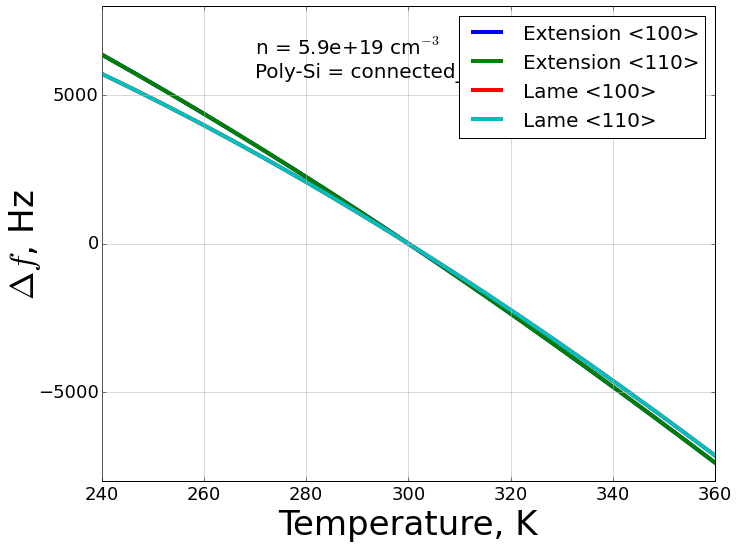

In [46]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
plt.ioff()
#styles = ['-', ':', '--', '-.']
#date_prefix = '2016-02-16--20-37' 
#mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
#              ('Lame', 0), ('Lame', 'pi4')]
mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
              ('Lame', 0), ('Lame', 'pi4')]
styles = ['-']*len(mode_pairs)
print date_prefix
for y_dim in ['Hz', 'ppm']:
    fig = plt.figure(figsize=(11,8.5))
    ax = fig.add_subplot(111)
    for (mode, direction), lst in zip(mode_pairs, styles):
        if y_dim == 'ppm':
            ff = open('./linear_f_data/' + date_prefix + '_T_LinFreq_PPM_' + mode + '_' + str(direction) +'.dat', 'r')
        else:
            ff = open('./linear_f_data/' + date_prefix + '_T_LinFreq_' + mode + '_' + str(direction) +'.dat', 'r')
        T_range, f_range = pickle.load(ff)
        #doping_range = np.linspace(1., 500., 50)
        ff.close()    
        ax.plot(T_range, f_range, linestyle = lst, lw = 4, label = mode +  \
                ' ' + direction_label(direction) + '')
    plot_margin = 0.1
    x0, x1, y0, y1 = ax.axis()
    ax.axis((x0 - plot_margin,
              x1 + plot_margin,
              y0 - plot_margin,
              y1 + plot_margin))    
    ax.legend(loc = 1, fontsize = 20)
    ax.set_xlabel('Temperature, K', fontsize = 34)
    ax.set_ylabel('$\Delta f$, ' + y_dim, fontsize = 34)
    ax.yaxis.set_label_coords(-0.095, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.grid(b=True, which='major', color='0.7', linestyle='-')
    ax.grid(b=True, which='minor', color='0.5', linestyle='--')
    if y_dim == 'Hz':
        ff2 = open('./linear_f_data/'+ date_prefix + '_parameters.txt', 'r')
        lines = ff2.readlines()
        ff2.close()
    ax.text(270, ax.get_ylim()[1]*0.8 , lines[1].rstrip() + " cm$^{{-3}}$", size=20)
    ax.text(270, ax.get_ylim()[1]*0.7 , lines[2].rstrip(), size=20)
    #fig.subplots_adjust()
    fig.savefig('./linear_f_data/' + date_prefix + '_' + 'Lin_Freq_T_' + y_dim +'.png')
    fig.savefig('./linear_f_data/' + date_prefix + '_' + 'Lin_Freq_T_' + y_dim +'.pdf')
plt.close(fig)

## Linear Frequency T-slope: calculate and save

In [64]:
import datetime
poly_si = 'isolated_gr' #'connected_gr' for connected grains, 'isolated_gr' for isolated grains
# 'single' for a single crystal
dimensions_Ext = (600.*10**(-4), 300.*10**(-4), 20.*10**(-4))  # cm
dimensions_Lame = (400.*10**(-4), 400.*10**(-4), 20.*10**(-4))  # cm
N_range = np.linspace(10**18, 2*10**20, 60) #in cm^-3
T_ = 300 #K
dT = 1. #K used for T-derivative
#mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
#              ('Lame', 0), ('Lame', 'pi4')]
mode_pairs = [('Extension', 0),\
              ('Lame', 0)]
date_prefix = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M')
print date_prefix
for mode, direction in mode_pairs:
    print '{}-{}'.format(mode, direction)
    if mode == 'Extension':
        dimensions = dimensions_Ext
    else:
        dimensions = dimensions_Lame
    dfdT_range = []
    for N_ in N_range:
        f_plus = linear_frequency(mode, direction, T_ + 0.5*dT, N_, dimensions, poly_si)
        f_minus = linear_frequency(mode, direction, T_ - 0.5*dT, N_, dimensions, poly_si)
        dfdT = (f_plus - f_minus)/dT
        dfdT_range.append(dfdT)
    #Shift frequency to 0 Hz at 300 K:
    dfdT_range = np.array(dfdT_range)
    #save data
    data_fname = './linear_f_slope/' + date_prefix + '_T_lin_slope_' + mode + '_' + str(direction) + '.dat'
    if not os.path.exists(os.path.dirname(data_fname)):
        os.makedirs(os.path.dirname(data_fname))
        print './linear_f_slope/ created'
    ff = open(data_fname, 'w')
    pickle.dump((N_range, dfdT_range), ff)
    ff.close()
ff2 = open('./linear_f_slope/'+ date_prefix + '_parameters.txt', 'w')
ff2.write(str(params) + '\n')
ff2.write('T = {} K\n'.format(T_))
ff2.write('Poly-Si = {}\n'.format(poly_si))
ff2.close()
print '=============== Done! ================'

2016-07-05--16-58
Extension-0
Lame-0
=============== Done! ================


## Plot Linear Frequency T-slope

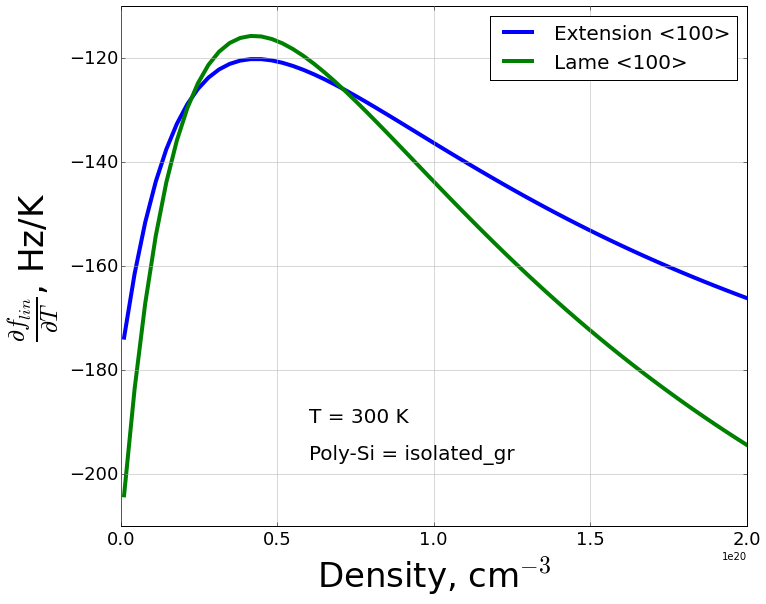

In [65]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
#styles = ['-', ':', '--', '-.']
#date_prefix = '2016-02-09--11-52' 
#mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
#              ('Lame', 0), ('Lame', 'pi4')]
mode_pairs = [('Extension', 0),\
              ('Lame', 0)]
styles = ['-']*len(mode_pairs)
fig = plt.figure(figsize=(11,8.5))
ax = fig.add_subplot(111)
for (mode, direction), lst in zip(mode_pairs, styles):
    ff = open('./linear_f_slope/' + date_prefix + '_T_lin_slope_' + mode + '_' + str(direction) +'.dat', 'r')
    N_range, f_range = pickle.load(ff)
    ff.close()
    ax.plot(N_range, f_range, linestyle = lst, lw = 4, label = mode +  \
            ' ' + direction_label(direction) + '')
x0, x1, y0, y1 = ax.axis()
   
ax.legend(loc = 1, fontsize = 20)
ax.set_xlabel('Density, cm$^{{-3}}$', fontsize = 34)
ax.set_ylabel('$\\frac{\\partial f_{lin}}{\\partial T}$, Hz/K', fontsize = 34)
ax.yaxis.set_label_coords(-0.095, 0.5)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.grid(b=True, which='major', color='0.7', linestyle='-')
ax.grid(b=True, which='minor', color='0.5', linestyle='--')

ff2 = open('./linear_f_slope/'+ date_prefix + '_parameters.txt', 'r')
lines = ff2.readlines()
ff2.close()
text_pos = [0.6*10**20, ax.get_ylim()[0] + 0.2*(ax.get_ylim()[1] - ax.get_ylim()[0])]
ax.text(text_pos[0], text_pos[1] , lines[1].rstrip(), size=20)
ax.text(text_pos[0], text_pos[1] - 0.07*(ax.get_ylim()[1] - ax.get_ylim()[0])\
        , lines[2].rstrip(), size=20) #poly_si text
plt.subplots_adjust(left=0.16, right=0.95, top=0.95, bottom=0.1)
fig.savefig('./linear_f_slope/' + date_prefix + '_' + 'Lin_f_slope_N' +'.pdf')
plt.show()

# Calculate and save the symbolic expressions for elastic energy U(Q)

In [33]:
mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
              ('Lame', 0), ('Lame', 'pi4')]
for mode, direction in mode_pairs:
    alph = direction_to_alpha(direction)
    #U_terms(mode, doping, Tempr, alpha, numeric, poly_si)
    U = U_terms(mode, 1, 1, alph, False, 'single')
    pickle.dump(U, file('U_'+ mode +'_' + str(direction) +'.dat','w'))
    print 'U_'+ mode +'_' + str(direction) +'.dat'

integration done
U_Extension_0.dat
integration done
U_Extension_pi4.dat
integration done
U_Lame_0.dat
integration done
U_Lame_pi4.dat


# Nonlinear Frequency shift vs concentration (calculate and save)

In [ ]:
'''  Frequency shift vs concentration  '''
import datetime
numeric = True
omega_0n = 1.
T_ = 300.
poly_si = 'single' # 'connected_gr', 'isolated_gr'
doping_min, doping_max = (float(10**18), float(3e20))
NN = 60 #Number of points
doping_range = np.exp(np.linspace(np.log(doping_min), np.log(doping_max), NN)) #in cm^-3

a_x = 100. #np.sqrt(10**(-13))*100 #cm  Amplitude of the resonator edge
unit_a = False # If True, calculate \delta f/a^2; if false, calculate \delta f using a_x
paper_style = True # calculate \delta omega/omega0/eps^2, where eps = a_x/l_x

dimensions_LE = (600.e-4, 300.e-4, 20.e-4)  # cm
dimensions_Lame = (400.e-4, 400.e-4, 20.e-4)  # cm
d0_dict = {'Extension_0': 1.1e-4, 'Extension_pi4': 1.1e-4, 'Lame_0': 1.1e-4, 'Lame_pi4': 1.1e-4} #gaps in cm
Vb_dict = {'Extension_0': 25., 'Extension_pi4': 25., 'Lame_0': 25., 'Lame_pi4': 25.} #Bias V in Volt

om2_ranges = []
mode_pairs = [('Extension', '0'),('Extension', 'pi4'),\
              ('Lame', '0'), ('Lame', 'pi4')]
date_prefix = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M')
print date_prefix

for mode, direction in mode_pairs:
    print '---------------{}-{}----------------'.format(mode, direction)
    if mode == 'Extension':
        dimensions = dimensions_LE
    else:
        dimensions = dimensions_Lame
    a = np.pi*a_x/dimensions[0]
    df_array = []
    f_array = []
    alph = direction_to_alpha(direction)
    for N_ in doping_range:
        om2 = omega_corr(mode, direction, N_, T_, numeric, poly_si)
        f = linear_frequency(mode, direction, T_, N_, dimensions, poly_si)
        f_array.append(f) 
        if unit_a:
            multpl = 1
        else:
            multpl = a**2
        d0_ = d0_dict[mode + '_' + direction]
        Vb_ = Vb_dict[mode + '_' + direction]
        df_array.append(evaluate_coeff(om2, N_, T_, omega_0n, dimensions, alph, d0_, Vb_, poly_si)*f*multpl)
        
    #save data
    data_fname = './nl_f_shift/'+ date_prefix + '_concentration_omega_' + mode + '_' + str(direction) +'.dat'
    if not os.path.exists(os.path.dirname(data_fname)):
        os.makedirs(os.path.dirname(data_fname))
        print './nl_f_shift/ created'
    ff = open(data_fname, 'w')
    pickle.dump((doping_range, df_array, f_array), ff)
    ff.close()    
#Save parameters used:
param_fname = './nl_f_shift/'+ date_prefix + '_concentration_omega_parameters.txt'
ff2 = open(param_fname, 'w')
params_copy = cp.deepcopy(params)
params_copy.update({'unit_a': unit_a, 'a_x': a_x, 'lx_ext': dimensions_LE[0], 'lx_lame': dimensions_Lame[0]})
ff2.write(str(params_copy) + '\n')
ff2.write('$T$ = {} K\n'.format(int(T_)))
ff2.write('a_x = {} #cm\nunit_a = {}\n'.format(a_x, unit_a))
ff2.write('d0 = {}\n'.format(d0_dict))
ff2.write('Vb = {}\n'.format(Vb_dict))
ff2.write('Poly-Si = {}\n'.format(poly_si))
ff2.close()
print '=============== Done! ================'

In [7]:
plt.close('all')

## Plot nonlinear shift vs concentration
Can plot the data stored in .dat files from previous runs

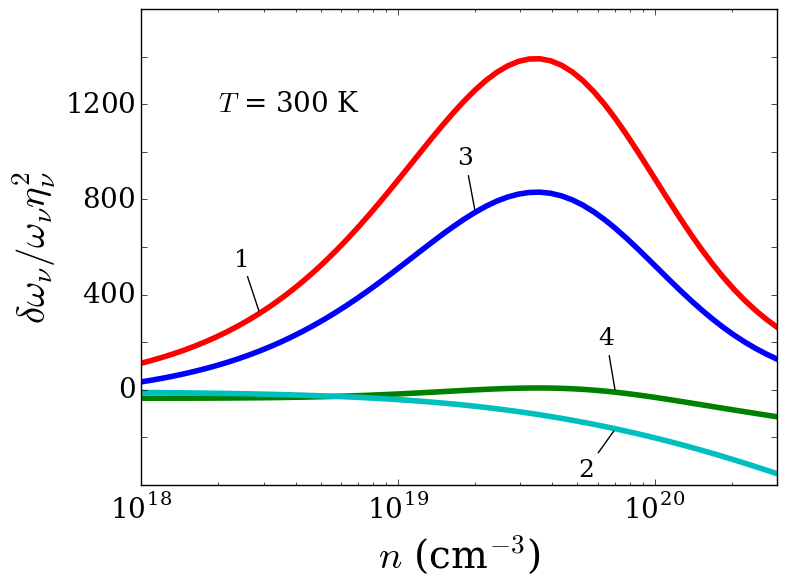

In [23]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

    
date_prefix = '2016-11-13--20-29' #beginning of the data files
y_style = 'paper' # 'paper': use y-axis units as in the paper. Any other value: y-units Hz/m^2 or Hz
plt.close('all')
plt.rc('font', family='serif')
plot_type = "Concentration"# "Temperature" # 
mode_pairs = [('Extension', '0'), ('Extension', 'pi4'),\
              ('Lame', '0'), ('Lame', 'pi4')]
#labels and their coordinates: [('label', x-data_point, x_offset of label, y_offset of label), ...]
clabels = [('3', 2e19, -3e18, 200), ('4', 7e19, -1e19, 200),\
           ('1', 3e18, -0.6e18, 200), ('2', 7e19, -2.0e19, -200)]
# read the parameters:
ff2 = open('./nl_f_shift/'+ date_prefix + '_concentration_omega_parameters.txt', 'r')
lines = ff2.readlines()
ff2.close()
params_plot = eval(lines[0])

styles = ['-']*len(mode_pairs)
#styles = ['-','--', ':' , '-.']
colors = [ 'b',  'g', 'r', 'c']
#colors = ['k']*4
label_dict = {'Extension': 'Extension', 'Lame': u"Lamé"}
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
xfmt = plt.ScalarFormatter(useMathText = True)
for (mode, direction), lst, clr, clabel in zip(mode_pairs, styles, colors, clabels):
    ff = open('./nl_f_shift/'+ date_prefix + '_' + plot_type +'_omega_' + mode + '_' + str(direction) +'.dat', 'r')
    data = pickle.load(ff)
    ff.close()  
    doping_range, df2_array = (np.array(data[0]), np.array(data[1]))
    if y_style == 'paper': # on y axis: (delta f)/f/eps^2, where eps = A_x/l_x; A_x = sqrt(2)*a_x
        #A_x - amplitude in paper, a_x amplitude of the edge
        f_array = np.array(data[2])
        if params_plot['unit_a']: #means df_array = df_hz/(pi*a_x/l_x)^2
            mult = 2*np.pi**2/f_array
        else:
            if mode == 'Extension':
                mult = 2*params_plot['lx_ext']**2/params_plot['a_x']**2/f_array
            elif mode == 'Lame':
                mult = 2*params_plot['lx_lame']**2/params_plot['a_x']**2/f_array
            else:
                print 'Mode should be Extension or Lame'
                break
    else:
        mult = 1
    #ax.plot(doping_range, df2_array*mult, linestyle = lst, lw = 4, label = mode +  \
    #        ' ' + direction_label(direction) + '')
    ax.semilogx(doping_range, df2_array*mult, linestyle = lst, lw = 4, color = clr, label = label_dict[mode] +  \
            ' ' + direction_label(direction) + '')
    annotate_curve(ax, clabel[0], clabel[1], doping_range, df2_array*mult, clabel[2], clabel[3])
#ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(xfmt)


# Add text notes:
text_pos = [2*10**18, ax.get_ylim()[0] + 0.8*(ax.get_ylim()[1] - ax.get_ylim()[0])]
ax.text(text_pos[0], text_pos[1] , lines[1], size=20)

if lines[6] != 'Poly-Si = single\n':
        ax.text(text_pos[0], text_pos[1] - 0.15*(ax.get_ylim()[1] - ax.get_ylim()[0]),\
                lines[6].rstrip(), size=20)


#ax.legend(loc = 1, fontsize = 14)

ax.set_xlabel('$n$ (cm$^{-3}$)', fontsize = 28)
if y_style == 'paper':
    ax.set_ylabel('$\\delta \\omega_\\nu/\\omega_\\nu\\eta_\\nu^2$', fontsize = 28)
else:
    try:
        if params_plot['unit_a']:
            ax.set_ylabel('$\\delta f/\\varepsilon^2}$ (Hz)', fontsize = 28)
        else:
            ax.set_ylabel('$\\delta f}$ (Hz)', fontsize = 28)
            ax.text(text_pos[0], text_pos[1] - 0.05*(ax.get_ylim()[1] - ax.get_ylim()[0]) , '$a_x^2=' +\
            latex_float(str(params_plot['a_x']**2)) + '$ cm$^2$', size=20)
    except:
        ax.set_ylabel('$\\delta f/a^2}$ (Hz)', fontsize = 34)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=16)
ax.xaxis.set_ticks([10**18, 10**19, 10**20])
ax.yaxis.set_ticks(np.arange(-400, 1600, 200))
#Hide some y-axis tick labels:
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.yaxis.get_ticklabels()[0].set_visible(False)
ax.yaxis.get_ticklabels()[-1].set_visible(False)

ax.set_xlim((1e18, 3e20))
ax.set_ylim((-400, 1600))
ax.tick_params(axis='x', which='major', pad=6)
t = ax.yaxis.get_offset_text()
t.set_size(18)
t = ax.xaxis.get_offset_text()
t.set_size(18)
#ax.grid(b=True, which='major', color='0.7', linestyle='-')
#ax.grid(b=True, which='minor', color='0.5', linestyle='--')

fig.tight_layout()
fig.savefig('./nl_f_shift/'+ date_prefix + '_' + plot_type +'.png')
fig.savefig('./nl_f_shift/'+ date_prefix + '_' + plot_type +'.eps')
#fig.show()

# Nonlinear Frequency shift vs $T$: calculate and save

In [ ]:
'''  Frequency shift vs concentration  '''
import datetime
numeric = True
poly_si = 'single' # 'single' 'connected_gr', 'isolated_gr'
omega_0n = 1.
N_ = 5.9*10**19 #cm^-3
dimensions_LE = (600.e-4, 300.e-4, 20.e-4)  # cm
dimensions_Lame = (400.e-4, 400.e-4, 20.e-4)  # cm
d0_dict = {'Extension_0': 1.1e-4, 'Extension_pi4': 1.1e-4, 'Lame_0': 1.1e-4, 'Lame_pi4': 1.1e-4} #gaps in cm
Vb_dict = {'Extension_0': 0., 'Extension_pi4': 0., 'Lame_0': 0., 'Lame_pi4': 0.} #Bias V in Volt
T_range = np.linspace(70, 450, 60) #in cm^-3
mode_pairs = [('Extension', '0'), ('Extension', 'pi4'),\
              ('Lame', '0'), ('Lame', 'pi4')]

date_prefix = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M')
#a_x = np.sqrt(10**(-13))*100 #cm  Amplitude of the resonator edge
a_x = 100. #cm  Amplitude of the resonator edge
unit_a = True # If True, calculate \delta f/a^2, if false, calculate \delta f using a_x


print date_prefix
for mode, direction in mode_pairs:
    print '{}-{}'.format(mode, direction)
    if mode == 'Extension':
        dimensions = dimensions_LE
    else:
        dimensions = dimensions_Lame
    df_array = []
    f_array = []
    alph = direction_to_alpha(direction)
    a = np.pi*a_x/dimensions[0]
    for T_ in T_range:
        if unit_a:
            multpl = 1
        else:
            multpl = a**2
        
        om2 = omega_corr(mode, direction, N_, T_, numeric, poly_si)
        f = linear_frequency(mode, direction, T_, N_, dimensions, poly_si)
        f_array.append(f)
        d0_ = d0_dict[mode + '_' + direction]
        Vb_ = Vb_dict[mode + '_' + direction]
        df_array.append(evaluate_coeff(om2, N_, T_, omega_0n, dimensions, alph, d0_, Vb_, poly_si)*f*multpl)
    #save data
    data_fname = './T_nl_f_shift/'+ date_prefix + '_Temperature_omega_' + mode + '_' + str(direction) +'.dat'
    if not os.path.exists(os.path.dirname(data_fname)):
        os.makedirs(os.path.dirname(data_fname))
        print './T_nl_f_shift/ created'
    ff = open(data_fname, 'w')
    pickle.dump((T_range, df_array, f_array), ff)
    ff.close()    
#Save parameters used:
ff2 = open('./T_nl_f_shift/'+ date_prefix + '_T_omega_parameters.txt', 'w')
params_copy = cp.deepcopy(params)
params_copy.update({'unit_a': unit_a, 'a_x': a_x, 'lx_ext': dimensions_LE[0], 'lx_lame': dimensions_Lame[0]})
ff2.write(str(params_copy) + '\n')
ff2.write('n = {}\n'.format(N_))
ff2.write('a_x = {} #cm\nunit_a = {}\n'.format(a_x, unit_a))
ff2.write('d0 = {}\n'.format(d0_dict))
ff2.write('Vb = {}\n'.format(Vb_dict))
ff2.write('Poly-Si = {}\n'.format(poly_si))
ff2.close()
print '=============== Done! ================'

## Plot nonlinear frequency shift vs T

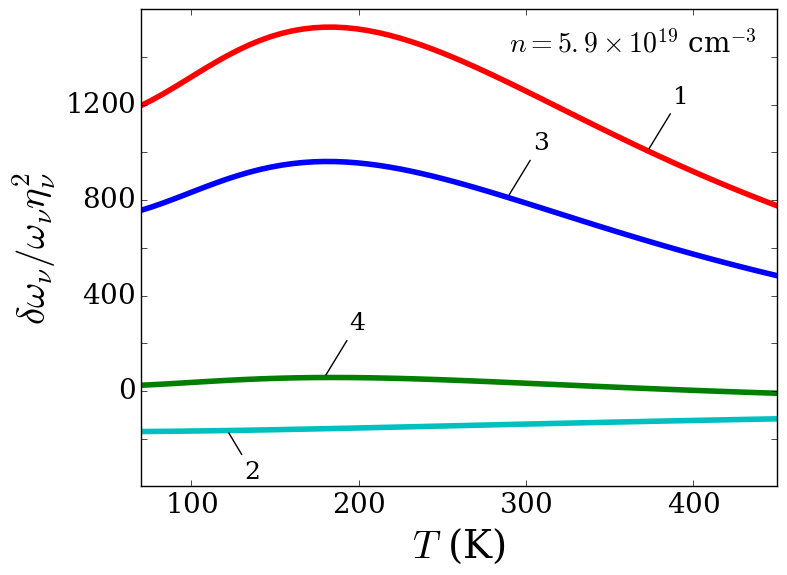

In [24]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
#styles = ['-', ':', '--', '-.']
plt.close('all')
date_prefix = '2016-11-13--22-42' #look for data files that start with this
y_style = 'paper'
plot_type = "Temperature"# 
mode_pairs = [('Extension', '0'), ('Extension', 'pi4'),\
              ('Lame', '0'), ('Lame', 'pi4')]
#mode_pairs = [('Extension', '0'),\
#              ('Lame', '0')]
clabels = [('3', 290, 15, 200), ('4', 180, 15, 200),\
           ('1', 370, 15, 200), ('2', 120, 10, -200)]
# read the parameters:
ff2 = open('./T_nl_f_shift/'+ date_prefix + '_T_omega_parameters.txt', 'r')
lines = ff2.readlines()
ff2.close()
params_plot = eval(lines[0])

styles = ['-']*len(mode_pairs)
fig = plt.figure(figsize=(8,5.87))
plt.rc('font', family='serif')
ax = fig.add_subplot(111)
xfmt = plt.ScalarFormatter(useMathText = True) #label formatting '\times 10^n'
for (mode, direction), lst, clabel in zip(mode_pairs, styles, clabels):
    ff = open('./T_nl_f_shift/'+ date_prefix + '_' + plot_type +'_omega_' + mode + '_' + str(direction) +  '.dat', 'r')
    data = pickle.load(ff)
    ff.close()
    doping_range, om2_array = [np.array(x) for x in data[:2]]
    if y_style == 'paper': # on y axis: (delta f)/f/eps^2, where eps = A_x/l_x; A_x = sqrt(2)*a_x
        #A_x - amplitude in paper, a_x amplitude of the edge
        f_array = np.array(data[2])
        if params_plot['unit_a']: #means df_array = df_hz/(pi*a_x/l_x)^2
            mult = 2*np.pi**2/f_array
        else:
            if mode == 'Extension':
                mult = 2*params_plot['lx_ext']**2/params_plot['a_x']**2/f_array
            elif mode == 'Lame':
                mult = 2*params_plot['lx_lame']**2/params_plot['a_x']**2/f_array
            else:
                print 'Mode should be Extension or Lame'
                break
    else:
        mult = 1
    ax.plot(doping_range, om2_array*mult, linestyle = lst, lw = 4, label = mode +  \
            ' ' + direction_label(direction) + '')
    annotate_curve(ax, clabel[0], clabel[1], doping_range, om2_array*mult, clabel[2], clabel[3])

ax.xaxis.set_major_formatter(xfmt)
ax.yaxis.set_major_formatter(xfmt)
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(18.5, 10.5)
ff2 = open('./T_nl_f_shift/'+ date_prefix + '_T_omega_parameters.txt', 'r')
lines = ff2.readlines()
ff2.close()

xlim, ylim = ax.get_xlim(), ax.get_ylim()
text_pos = [xlim[0] + 0.6*(xlim[1] - xlim[0]),\
            ylim[1] - 0.1*(ylim[1] - ylim[0])]
delta_text_pos = 0.1*(ylim[1] - ylim[0])
ax.text(text_pos[0], text_pos[1] , make_param_text(lines[1].rstrip()) + ' cm$^{-3}$', size=20) # n = ... cm^-3
ax.set_ylim((ylim[0], 1.17*ylim[1]))
if lines[6] != 'Poly-Si = single\n':
        ax.text(text_pos[0], text_pos[1] - 0.15*(ax.get_ylim()[1] - ax.get_ylim()[0]),\
                lines[6].rstrip(), size=20)

a_x = float(lines[2].split(' ')[2])
unit_a = eval(lines[3].split(' ')[2])

ax.set_ylim([-200,1600])
ax.set_xlim([70,450]) 
#ax.legend(loc = 1, fontsize = 14)
ax.set_xlabel('$T$ (K)', fontsize = 28)
if y_style == 'paper':
    ax.set_ylabel('$\\delta \\omega_\\nu/\\omega_\\nu\\eta_\\nu^2$', fontsize = 28)
else:
    if unit_a:
        ax.set_ylabel('$\\delta f/\\varepsilon^2$ (Hz)', fontsize = 28)
    elif a_x == 100:
        ax.set_ylabel('$\\delta f/a_x^2$ (Hz/m$^2$)', fontsize = 28)
    else:
        ax.set_ylabel('$\\delta f$, Hz', fontsize = 28)
        ax.text(text_pos[0], text_pos[1] - delta_text_pos , '$a_x =$ {:.3e} cm'.format(a_x), size=20)
    
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=16)
t = ax.yaxis.get_offset_text()
t.set_size(18)

ax.xaxis.set_ticks([100, 200, 300, 400])
ax.yaxis.set_ticks(np.arange(-400, 1600, 200))
#Hide some y-axis tick labels:
for label in ax.yaxis.get_ticklabels()[1::2]:
    label.set_visible(False)
ax.yaxis.get_ticklabels()[0].set_visible(False)
ax.yaxis.get_ticklabels()[-1].set_visible(False)

#ax.grid(b=True, which='major', color='0.7', linestyle='-')
#ax.grid(b=True, which='minor', color='0.5', linestyle='--')
#plt.title('Frequency correction')
#fig.subplots_adjust()
fig.tight_layout()
fig.savefig('./T_nl_f_shift/'+ date_prefix + '_' + plot_type +'.png')
fig.savefig('./T_nl_f_shift/'+ date_prefix + '_' + plot_type +'.eps')
#fig.show()

# Plot $c_{ij...}$ vs. $n$:

In [ ]:
'''  delta_c correction vs concentration  '''
omega_0 = 1.
c_items = ['1111']
doping_range = np.arange(10**10, 0.2*10**21, 2*10**18) #in cm^-3
Tempr = 300.          #K 
c_ranges = [[] for i in c_items]

for doping in doping_range:
    c = dcn_calc(doping, Tempr)
    for i, c_item in enumerate(c_items):
        c_ranges[i].append(c[c_item])

styles = ['-', '--', ':', '-.']       
for i, c_item in enumerate(c_items):
    plt.plot(doping_range/10.**20, c_ranges[i], c = 'k', linestyle = styles[i], label = '$\delta c_{' + c_item + '}$')


plt.legend(loc = 1, fontsize = 16)
plt.xlabel('Doping, $10^{20}$cm$^{-3}$', fontsize = 22)
plt.ylabel('Elastic constant, $10^{12}$dyn/cm$^2$', fontsize = 20)
plt.tight_layout()
#plt.title('c vs doping')
plt.savefig('c_1111_vs_doping.pdf')
#plt.show()
plt.clf()

# Print analytical expressions for $\delta\omega^{(2)}$:

In [111]:
mode, direction = 'Extension', '0'
subs_dict = {Vb: 0}
om2 = omega_corr(mode, direction, 1, 1, False, 'single').subs(subs_dict)
om2 = simplify(om2)
show_math('\\text{' + mode + '} ' + direction_label(direction)[1:-1] + ':')
show_math(om2, "\\delta \\omega^{(2)}=")

U_Extension_0.dat


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Without third-order $c_{ijk}$:

In [119]:
mode, direction = 'Extension', 0
subs_dict = {Vb: 0, c111: 0, c112:0, c123:0, nu2: nu, nu3: nu}
om2 = omega_corr(mode, direction, 1, 1, False, 'single').subs(subs_dict)
om2 = simplify(om2)
show_math('\\text{' + mode + '} ' + direction_label(direction)[1:-1] + ':')
show_math(om2, "\\delta \\omega^{(2)}\\approx")

U_Extension_0.dat


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [115]:
mode, direction = 'Extension', 'pi4'
subs_dict = {Vb: 0}
om2 = omega_corr(mode, direction, 1, 1, False, 'single').subs(subs_dict)
om2 = simplify(om2)
show_math('\\text{' + mode + '} ' + direction_label(direction)[1:-1] + ':')
show_math(om2, "\\delta \\omega^{(2)}=")

U_Extension_pi4.dat


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Without thrid-order $c_{ijk}$:

In [118]:
mode, direction = 'Extension', 'pi4'
subs_dict = {Vb: 0, c111: 0, c112:0, c123:0, c144: 0, c155: 0, nu2:nu2, nu3: nu3}
om2 = omega_corr(mode, direction, 1, 1, False, 'single').subs(subs_dict)
om2 = simplify(om2)
show_math('\\text{' + mode + '} ' + direction_label(direction)[1:-1] + ':')
show_math(om2, "\\delta \\omega^{(2)}\\approx")

U_Extension_pi4.dat


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [110]:
mode, direction = 'Lame', '0'
subs_dict = {Vb: 0}
om2 = omega_corr(mode, direction, 1, 1, False, 'single').subs(subs_dict)
om2 = simplify(om2)
show_math('\\text{' + mode + '} ' + direction_label(direction)[1:-1] + ':')
show_math(om2, "\\delta \\omega^{(2)}=")

U_Lame_0.dat


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [109]:
mode, direction = 'Lame', 'pi4'
subs_dict = {Vb: 0}
om2 = omega_corr(mode, direction, 1, 1, False, 'single').subs(subs_dict)
om2 = simplify(om2)
show_math('\\text{' + mode + '} ' + direction_label(direction)[1:-1] + ':')
show_math(om2, "\\delta \\omega^{(2)}=")

U_Lame_pi4.dat


<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Frequency and frequency shift in 'paper' notation:
Use the notation from the paper, where $A_x$ is used and $u$ field is normalized.
$$
    m\omega_0^2 = c^2U_2
$$
where $c^2 = 2\pi^2/l_x^2$ for Extension and $c^2 = \pi^2/2l_x^2$ for Lame. $U_2$ is the coefficient before the quadratic term in elastic energy and is defined in the code. $c$ is chosen so that $\int dr\, u^2(r) = V$, and $u_x = -\frac{cl_x}{\pi}\cos \frac{pi x}{l_x}$.

Same thing for $\gamma_\nu$:
$$
    \gamma_\nu = c^4 U_4
$$

In [1]:
def expressions_in_paper_notation(mode, direction, subs_dict, subs_dict2 = None, prnt = False):
    '''Using the conventions for modes described above (normalization, etc.) 
    show the components of the quartic frequency shift and linear frequency.
    This function does some simplification to present results in the most
    compact and readable way.
    '''
    if mode == 'Extension':
        c = sqrt(2)*pi/lx
    else:
        c = sqrt(2)*pi/lx
    U = U_terms(mode, 1, 1, direction_to_alpha(direction), False, 'single')
    U_dict = collect(U, Q, evaluate = False)
    U_2 = 2*U_dict[Q**2].subs(subs_dict)
    U_4 = 4*U_dict[Q**4].subs(subs_dict)
    
    momega2 = simplify(c**2*U_2)
    show_math(momega2, 'm\\omega_0^2 = ', prnt)
    if subs_dict2 != None:
        momega2 = simplify(c**2*U_2.subs(subs_dict2))
        show_math(momega2, 'm\\omega_0^2 = ', prnt) #prnt = True prints latex text
    gamma_nu = simplify(c**4*U_4)#.subs({nu: c12/(c11 + c12)}))
    show_math(gamma_nu, '\\gamma_\\nu = ', prnt)
    if mode == 'Extension' and direction == 'pi4':
        constants = [c1111, c1112, c1122, c1123, c1144, c1155, c1244, c1266, c4444,\
                     delta_c1111, delta_c1144, delta_c4444]
        expr = gamma_nu.args[-1]
        expr_terms = 0
        for cc in constants:
            try:
                expr_terms += factor(collect(expr, cc, evaluate = False)[cc])*cc
            except:
                pass
        gamma_nu = expr_terms*pi**4*ly*lz/32/lx**3
        show_math(gamma_nu, '\\gamma_\\nu = ', prnt)
    show_math(3*gamma_nu/8/momega2, '\\frac{3\\gamma_\\nu}{8m\\omega_0^2} = ', prnt)

## Extension $\langle 100\rangle$:

In [129]:
mode = 'Extension'
direction = '0'
subs_dict = {Vb: 0, nu2: nu, nu3: nu}
subs_d2 = {nu: c12/(c11 + c12)}
expressions_in_paper_notation(mode, direction, subs_dict,subs_dict2 = subs_d2, prnt = False)

integration done


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Extension $\langle 110\rangle$:

In [4]:
mode = 'Extension'
direction = 'pi4'
sigma2, sigma3, delta_c1111, delta_c1144, delta_c4444 = \
symbols('\\sigma_2 \\sigma_3 \\delta{c_{1111}} \\delta{c_{1144}} \\delta{c_{4444}}')
#subs_dict = {Vb: 0, nu2: sigma2, nu3: sigma3}
#expressions_in_paper_notation(mode, direction, subs_dict, subs_dict2 = None, prnt = False)
subs_dict = {Vb: 0, nu2: sigma2, nu3: sigma3, c1111: delta_c1111, c1112: -delta_c1111/2, \
            c1122: delta_c1111/2, c1144: delta_c1144, c1266: delta_c1144, c1244: -delta_c1144/2,\
             c1155: -delta_c1144/2, c4444: delta_c4444, c1123: 0}
expressions_in_paper_notation(mode, direction, subs_dict, subs_dict2 = None, prnt = False)

integration done


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Lame $\langle 100\rangle$:

In [136]:
mode = 'Lame'
direction = '0'
subs_dict = {Vb: 0}
subs_d2 = None
expressions_in_paper_notation(mode, direction, subs_dict,subs_dict2 = subs_d2, prnt = True)

integration done


<IPython.core.display.Math object>

m\omega_0^2 = \pi^{2} l_{z} \left(c_{11} - c_{12}\right)


<IPython.core.display.Math object>

\gamma_\nu = \frac{3 \pi^{4} l_{z}}{16 l_{x}^{2}} \left(c_{1111} - 4 c_{1112} + 3 c_{1122}\right)


<IPython.core.display.Math object>

\frac{3\gamma_\nu}{8m\omega_0^2} = \frac{9 \pi^{2} \left(c_{1111} - 4 c_{1112} + 3 c_{1122}\right)}{128 l_{x}^{2} \left(c_{11} - c_{12}\right)}


## Lame $\langle 110\rangle$:

In [138]:
mode = 'Lame'
direction = 'pi4'
subs_dict = {Vb: 0}
subs_d2 = None
expressions_in_paper_notation(mode, direction, subs_dict,subs_dict2 = subs_d2, prnt = True)

integration done


<IPython.core.display.Math object>

m\omega_0^2 = 2 \pi^{2} c_{44} l_{z}


<IPython.core.display.Math object>

\gamma_\nu = \frac{3 \pi^{4} c_{4444} l_{z}}{2 l_{x}^{2}}


<IPython.core.display.Math object>

\frac{3\gamma_\nu}{8m\omega_0^2} = \frac{9 \pi^{2} c_{4444}}{32 c_{44} l_{x}^{2}}


# Calculate $E$, $\nu_2$ and $\nu_3$
for $\langle 100\rangle$ and $\langle 110\rangle$ directions of the beam

In [34]:

numeric = False
direction = '110'
doping = 10**10
Tempr = 300.

elements_2d, elements_3d, elements_4d = c_elements(doping, Tempr, numeric)
#2d, 3d, 4d stand for c_ij, c_ijk, c_ijkl
if direction == '100':
    c_2d = construct_tensor(elements_2d, numeric)
    #c_3d = construct_tensor(elements_3d, numeric)
    #c_4d = construct_tensor(elements_4d, numeric)
elif direction == '110':
    c_2d = rotate_tensor(construct_tensor(elements_2d, numeric), pi/4 ,numeric)
    #c_3d = rotate_tensor(construct_tensor(elements_3d, numeric), ,numeric)
    #c_4d = rotate_tensor(construct_tensor(elements_4d, numeric), ,numeric)
else:
    print '"direction" in omega_corr_stretch must be either 100 or 110'
nu2s = (c_2d[0,1]*c_2d[2,2] - c_2d[0,2]**2)/(c_2d[0,0]*c_2d[2,2] - c_2d[0,2]**2)
nu3s = -c_2d[0,2]*(c_2d[0,1] - c_2d[0,0])/(c_2d[0,0]*c_2d[2,2] - c_2d[0,2]**2)
E = (c_2d[2,2]*(c_2d[0,0]**2 - c_2d[0,1]**2) - 2*c_2d[0,0]*c_2d[0,2]**2 + 2*c_2d[0,1]*c_2d[0,2]**2)/\
(c_2d[0,0]*c_2d[2,2] - c_2d[0,2]**2)
#print nu2s
#print nu3s
show_math(simplify(nu2s), '\\nu_2 = ', prnt = True)
show_math(simplify(nu3s), '\\nu_3 = ', prnt = True)
show_math(simplify(E), 'E = ', prnt = True)

<IPython.core.display.Math object>

\nu_2 = \frac{c_{11} \left(c_{11} + c_{12} - 2 c_{44}\right) - 2 c_{12}^{2}}{c_{11} \left(c_{11} + c_{12} + 2 c_{44}\right) - 2 c_{12}^{2}}


<IPython.core.display.Math object>

\nu_3 = \frac{4 c_{12} c_{44}}{c_{11} \left(c_{11} + c_{12} + 2 c_{44}\right) - 2 c_{12}^{2}}


<IPython.core.display.Math object>

E = \frac{4 c_{44} \left(c_{11}^{2} + c_{11} c_{12} - 2 c_{12}^{2}\right)}{c_{11}^{2} + c_{11} c_{12} + 2 c_{11} c_{44} - 2 c_{12}^{2}}


# Test Calculation

In [26]:
N_ = 2.*10**20 #cm^-3
T_ = 0.1*1.38*10**(-16) #erg
su_ = 9.0/(6.2415*10**11)
Ds_ = -100./(6.2415*10**11)
theta_0 = find_theta_0(N_, T_)
print "E_f = {} eV".format(theta_0*T_/(1.602177/10**12))
F0_ = fdint.fdk(0.5, theta_0)
F1_ = derivative(fdint.fdk, theta_0, 0.05)
F2_ = double_der(fdint.fdk, theta_0, 0.05)
F3_ = triple_der(fdint.fdk, theta_0, 0.05)


delta_11 = -2.*N_*su_**2*F1_[0]/9./T_/F0_[0]
print "delta_11 = {}".format(delta_11/10**12)
delta_12 = -delta_11/2.
print "delta_12 = {}".format(delta_12/10**12)
print ''
delta_111 = 2.*N_*su_**3*F2_[0]/27./T_**2/F0_[0]
print "delta_111 = {}".format(delta_111/10**12)
delta_112 = -delta_111/2.
print "delta_112 = {}".format(delta_112/10**12)
delta_123 = 2.*N_*su_**3*F2_[0]/27./T_**2/F0_[0]
print "delta_123 = {}".format(delta_123/10**12)
delta_144 = -N_*su_*Ds_*F1_[0]/9./F0_[0]/T_
print "delta_144 = {}".format(delta_144/10**12)
print "delta_155 = {}".format(delta_155/10**12)

E_f = [ 0.11783638] eV
delta_11 = -0.0734219517458
delta_12 = 0.0367109758729

delta_111 = 0.934623157695
delta_112 = -0.467311578847
delta_123 = 0.934623157695
delta_144 = 1.65199391428
delta_155 = -0.82599695714


In [33]:
N_ = 1.98*10**19
T_ = 298. #K

dcns = dcn_calc(N_, T_)
print "C_11 = {}".format(dcns['11'])
print "0.5(C_11-C_12) = {}".format(0.5*(dcns['11'] - dcns['12']))
print "C_44 = {}".format(dcns['44'])
print "C_44_1 = {}".format(dcns['44_1'])
print "C_44_2 (mass change) = {}\n".format(dcns['44_2'])
print "C_111 = {}".format(dcns['111'])
print "C_111+2C_123-3C_112 = {}".format(dcns['111'] + 2*dcns['123'] - 3*dcns['112'])

print "\nC_144 = {}".format(dcns['144'])
print "C_144_1 = {}".format(dcns['144_1'])
print "C_144_2 (mass change) = {}\n".format(dcns['144_2'])


print "C_144 - C_166 = {}".format(dcns['144'] - dcns['155'])
print "C_155 = {}".format(dcns['155'])
print "C_1111 = {}".format(dcns['1111'])
print "C_1112 = {}".format(dcns['1112'])
print "C_1122 = {}".format(dcns['1122'])
print "C_4444 = {}".format(dcns['4444'])
#print dcns.keys()

C_11 = -0.017079025126
0.5(C_11-C_12) = -0.0128092688445
C_44 = -0.0032181298603
C_44_1 = -0.00284393174718
C_44_2 (mass change) = -0.000374198113125

C_111 = 1.25184512312
C_111+2C_123-3C_112 = 5.63330305403

C_144 = 0.596292209061
C_144_1 = 0.520195489887
C_144_2 (mass change) = 0.0760967191744

C_144 - C_166 = 0.894438313592
C_155 = -0.298146104531
C_1111 = 408.337065287
C_1112 = -204.168532643
C_1122 = 204.168532643
C_4444 = -49.688230812


## Calculate $c_{ij}, c_{ijk}, c_{ijkl}$ vs concentration

In [43]:
'''  c_ij, c_ijk, c_ijkl vs concentration  '''
import datetime

numeric = True
T_ = 300.
doping_range = np.linspace(10**18, 2*10**20, 50) #in cm^-3
constants = ['11', '144', '12', '155', '4455', '1144', '1155', '44',\
             '1123', '1266', '456', '1111', '1456', '123', '111', '1244', '1122', '112', '4444', '1112']

date_prefix = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M')
print date_prefix

c_ranges = {}
for const in constants:
    c_ranges[const] = []

for n in doping_range:
    dcns = dcn_calc(n, T_)
    for const in constants:
        c_ranges[const].append(dcns[const])
    
#save data
for const in constants:
    ff = open('./c_ij_vs_n/'+ date_prefix + '_c_' + const + '_n_.dat', 'w')
    pickle.dump((doping_range, c_ranges[const]), ff)
    ff.close()

    
ff2 = open('./c_ij_vs_n/'+ date_prefix + '_c_n_parameters.txt', 'w')
ff2.write(str(params) + '\n')
ff2.write('T = {} K'.format(int(T_)))
ff2.close()
print '=============== Done! ================'


2016-02-17--13-46
=============== Done! ================


## Plot $c_{ij}, c_{ijk}, c_{ijkl}$ vs concentration or $T$

In [6]:
import numpy as np
from matplotlib import pyplot as plt
#styles = ['-', ':', '--', '-.']
date_prefix = '2016-02-17--13-46'
plot_type = "Concentration"# "Temperature" # 
constants = ['1111', '4444']

styles = ['-']*len(constants)
fig = plt.figure(figsize=(11,8.5))
ax = fig.add_subplot(111)
for const, lst in zip(constants, styles):
    ff = open('./c_ij_vs_n/'+ date_prefix + '_c_' + const + '_n_.dat', 'r')
    x_range, c_range = pickle.load(ff)
    ff.close()
    ax.plot(x_range, c_range, linestyle = lst, lw = 4, label = '$\\delta c_{{' + const + '}}$')
ff2 = open('./c_ij_vs_n/'+ date_prefix + '_c_n_parameters.txt', 'r')
lines = ff2.readlines()
ff2.close()
ax.text(1.*10**20, 320, lines[1], size=20)

#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(18.5, 10.5)
plot_margin = 100.
#x0, x1, y0, y1 = ax.axis()
#ax.axis((x0 - plot_margin - 0.1,
#          x1 + plot_margin,
#          y0 - plot_margin -0.05,
#          y1 + plot_margin))    
ax.legend(loc = 1, fontsize = 20)
if plot_type == 'Concentration':
    ax.set_xlabel('n, cm$^{-3}$', fontsize = 34)
else:
    ax.set_xlabel('T, K', fontsize = 34)
ax.set_ylabel('$\\delta c$, $10^{{12}}$dyn/cm$^2$', fontsize = 34)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', which='minor', labelsize=16)
t = ax.yaxis.get_offset_text()
t.set_size(18)
t = ax.xaxis.get_offset_text()
t.set_size(18)
ax.grid(b=True, which='major', color='0.7', linestyle='-')
ax.grid(b=True, which='minor', color='0.5', linestyle='--')

#ax.set_ylim([2,2])
plt.subplots_adjust(left=0.13, right=0.95, top=0.95, bottom=0.1)
c_str = '_'
for const in constants:
    c_str = c_str + const + '_'
fig.savefig('./c_ij_vs_n/'+ date_prefix + c_str + plot_type +'.pdf')

## Change of $c_{ij}$ with volume
considering third-order nonlienarity only, that is $c_{ijk}$

In [27]:
elements_2d, elements_3d, elements_4d = c_elements(N_, 200., numeric = False)
c2 = construct_tensor(elements_2d, numeric=False)
c3 = construct_tensor(elements_3d, numeric=False)
eps_xx, eps_yy, eps_zz, eps_yz, eps_xz, eps_xy = symbols('\\varepsilon_{xx} \\varepsilon_{yy} \\varepsilon_{zz} ' +\
                                                        '\\varepsilon_{yz} \\varepsilon_{xz} \\varepsilon_{xy}')
eps = [eps_xx, eps_yy, eps_zz, eps_yz, eps_xz, eps_xy]
F = Rational(1,2)*einsum('ij,i,j', c2, eps, eps) + Rational(1,6)*einsum('ijk,i,j,k', c3, eps, eps, eps)
c_11_V = diff(F, eps_xx, eps_xx)
Math(latex(c_11_V))

<IPython.core.display.Math object>

## Calculate linear $f$ at particular points

In [12]:
N_ = 5.9*10**18
dimensions_Ext = (600.*10**(-4), 300.*10**(-4), 20.*10**(-4))  # cm
dimensions_Lame = (400.*10**(-4), 400.*10**(-4), 20.*10**(-4))  # cm
#T_range = np.linspace(240, 360, 20) # K
T_range = [253, 283, 313, 343] # K
mode_pairs = [('Extension', 0), ('Extension', 'pi4'),\
              ('Lame', 0), ('Lame', 'pi4')]
date_prefix = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M')
print date_prefix
print 'Doping = {}'.format(N_)
for mode, direction in mode_pairs:
    print '\t{}-{}'.format(mode, direction)
    if mode == 'Extension':
        dimensions = dimensions_Ext
    else:
        dimensions = dimensions_Lame
    f_range = []
    for T_ in T_range:
        f = linear_frequency(mode, direction, T_, N_, dimensions)
        print '\t\tAt T = {} C, f0 = {} Hz'.format(T_ - 273, f)

2016-05-03--15-53
Doping = 5.9e+18
	Extension-0
		At T = -20 C, f0 = 6171423.33217 Hz
		At T = 10 C, f0 = 6178465.25247 Hz
		At T = 40 C, f0 = 6185195.62723 Hz
		At T = 70 C, f0 = 6191681.49925 Hz
	Extension-pi4
		At T = -20 C, f0 = 7087331.29506 Hz
		At T = 10 C, f0 = 7087091.49632 Hz
		At T = 40 C, f0 = 7086591.74125 Hz
		At T = 70 C, f0 = 7085887.02432 Hz
	Lame-0
		At T = -20 C, f0 = 8173724.10651 Hz
		At T = 10 C, f0 = 8185452.48637 Hz
		At T = 40 C, f0 = 8196728.46784 Hz
		At T = 70 C, f0 = 8207650.92706 Hz
	Lame-pi4
		At T = -20 C, f0 = 10355360.2204 Hz
		At T = 10 C, f0 = 10348977.8839 Hz
		At T = 40 C, f0 = 10342273.6082 Hz
		At T = 70 C, f0 = 10335319.4871 Hz


## $\theta_0$ calculation:
$\theta_0 = \mu_0/T$

In [5]:
N_ = 1.*10**21 #cm^-3
T_ = 300*1.38*10**(-16) #erg

theta_0 = find_theta_0(N_, T_)
print theta_0[0]

13.2720594271
